In [1]:
%load_ext autoreload
%autoreload 2

import os, math, time, random
import json
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from collections import Counter

# your helpers
import data_utils as du
import dataset    as ds
import model_bs   as mdl
import metrics    as met
from inference   import reconstruct_smiles_table  # we'll use this at the end

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("CUDA devices:", torch.cuda.device_count(), [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Device: cuda
CUDA devices: 2 ['Tesla V100-SXM2-16GB', 'Tesla V100-SXM2-16GB']


In [2]:
# ==== EDIT THESE 3 PATHS IF NEEDED ====
UNION_CSV   = "/home/md_halim_mondol/Data/union.csv"
VOC_DYE_CSV = "/home/md_halim_mondol/Data/VOC_Dye.csv"
PRETRAINED  = "/home/md_halim_mondol/LSTM_VAE_Paper/checkpoints/best_model.pth"  # your trained base VAE

# ========= Finetune hyperparameters =========
cfg = dict(
    # data
    seq_length  = 160,
    batch       = 512,     # keep modest for stability on small data

    # model (must match your base checkpoint dims)
    d_model     = 256,
    latent_dim  = 64,
    enc_layers  = 3,
    dec_layers  = 7,
    dropout     = 0.05,
    emb_dropout = 0.05,

    # special token indices (must match your vocab)
    pad_idx     = 0,
    sos_idx     = 2,
    eos_idx     = 3,

    # optimization
    lr          = 1e-5,     # small LR for finetune
    weight_decay= 1e-5,
    epochs      = 20,
    early_stop  = 5,
    early_stop_min_delta = 1e-4,
    clip_grad   = 1.0,

    # KL schedule (tiny for small data)
    kl_anneal   = 5,
    kl_max      = 0.02,

    # regularization
    label_smoothing = 0.05,
    corruption_p    = 0.05,  # decoder word-dropout (if your model forward supports it)
    beam_size      = 5,     # for validation
    # I/O
    save_dir    = "./checkpoints_finetune",
    save_name   = "vae_finetuned.pth",
)
os.makedirs(cfg["save_dir"], exist_ok=True)

In [3]:
# Load CSVs
df_union = pd.read_csv(UNION_CSV)
df_voc   = pd.read_csv(VOC_DYE_CSV)

assert "smiles" in df_union.columns, f"'smiles' column not found in {UNION_CSV}"
assert "Analyte_SMILES" in df_voc.columns and "Dye_SMILES" in df_voc.columns, \
       f"VOC_Dye.csv must contain 'Analyte_SMILES' and 'Dye_SMILES'"

# unify into one column called 'smiles'
df_voc_long = pd.concat([
    df_voc[["Analyte_SMILES"]].rename(columns={"Analyte_SMILES": "smiles"}),
    df_voc[["Dye_SMILES"]].rename(columns={"Dye_SMILES": "smiles"})
])

# concat everything
df_all = pd.concat([df_union[["smiles"]], df_voc_long], ignore_index=True)
df_all = df_all.dropna().drop_duplicates()
print("Total unique SMILES after concat:", len(df_all))

# shuffle and split 80/20
df_all = df_all.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
split = int(0.8 * len(df_all))
train_smiles = df_all["smiles"].iloc[:split].tolist()
val_smiles   = df_all["smiles"].iloc[split:].tolist()

print(f"Train size: {len(train_smiles)} | Val size: {len(val_smiles)}")

Total unique SMILES after concat: 18840
Train size: 15072 | Val size: 3768


In [4]:
with open("/home/md_halim_mondol/LSTM_VAE_Paper/vocab.json") as f:
    token_to_idx = json.load(f)
idx_to_token = {i: t for t, i in token_to_idx.items()}

missing = Counter()
for smi in df_all["smiles"]:
    for tok in du.tokenize_smiles(smi):
        if tok not in token_to_idx:
            missing[tok] += 1

if missing:
    print("❌ Missing tokens in vocab:", missing)
else:
    print("✅ All tokens covered by existing vocab.json")

✅ All tokens covered by existing vocab.json


In [5]:
augmentor = du.SmilesEnumerator()

train_ds = ds.SMILESDataset(train_smiles, seq_length=cfg["seq_length"], token_to_idx=token_to_idx, augmentor=augmentor, augment_train=True)
val_ds   = ds.SMILESDataset(val_smiles, seq_length=cfg["seq_length"], token_to_idx=token_to_idx, augmentor=None, augment_train=False)

train_dl = DataLoader(train_ds, batch_size=cfg["batch"], shuffle=True,  num_workers=8, pin_memory=True, prefetch_factor=2)
val_dl   = DataLoader(val_ds,   batch_size=cfg["batch"], shuffle=False, num_workers=8, pin_memory=True, prefetch_factor=2)

In [6]:
# Build the same model architecture as your pretrained one
base_model = mdl.CNNCharVAE(
    vocab_size=len(token_to_idx),
    d_model=cfg["d_model"],
    latent_dim=cfg["latent_dim"],
    pad_idx=cfg["pad_idx"],
    sos_idx=cfg["sos_idx"],
    eos_idx=cfg["eos_idx"],
    enc_layers=cfg["enc_layers"],
    dec_layers=cfg["dec_layers"],
    dropout=cfg["dropout"],
    emb_dropout=cfg["emb_dropout"],
    max_len=cfg["seq_length"],
).to(device)

# Load base pretrained weights
state = torch.load(PRETRAINED, map_location=device)
base_model.load_state_dict(state, strict=True)
print("Loaded pretrained weights from:", PRETRAINED)

# Use all GPUs if available (no base model code changes)
model = nn.DataParallel(base_model) if torch.cuda.device_count() > 1 else base_model
m = model.module if isinstance(model, nn.DataParallel) else model
for p in m.encoder.parameters():
    p.requires_grad = False

# quick checksum
s = sum(p.detach().float().abs().sum().item() for p in m.parameters())
print("Model checksum:", s)

Loaded pretrained weights from: /home/md_halim_mondol/LSTM_VAE_Paper/checkpoints/best_model.pth
Model checksum: 206159.40872502327


/var/tmp/ipykernel_552587/2370819124.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(PRETRAINED, map_location=device)


In [7]:
import inspect

opt = torch.optim.AdamW([
    {"params": m.encoder.parameters(), "lr": cfg["lr"] * 0.2},   # smaller LR
    {"params": m.decoder.parameters(), "lr": cfg["lr"]}],         # normal LR
 weight_decay=cfg["weight_decay"])

use_amp = torch.cuda.is_available()
scaler  = torch.cuda.amp.GradScaler(enabled=use_amp)

# %%
def kl_weight(ep: int) -> float:
    warm = min(ep / cfg["kl_anneal"], 1.0) * cfg["kl_max"]
    return min(warm, 0.02) if ep <= cfg.get("kl_plateau_until", 5) else warm

def _supports_kw(model, kw: str) -> bool:
    m = model.module if isinstance(model, nn.DataParallel) else model
    sig = inspect.signature(m.forward)
    return kw in sig.parameters

def train_one_epoch_tf(model, loader, optimizer, scaler, pad_idx, eos_idx, kl_w,
                       device, corruption_p, label_smoothing, clip_grad, use_amp):
    model.train()
    total_loss = total_corr = total_tok = 0
    pass_corrup = _supports_kw(model, "corruption_p")

    for inp, tgt in loader:
        inp, tgt = inp.to(device, non_blocking=True), tgt.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            fwd_kwargs = dict(tgt=tgt, teacher_forcing=True)
            if pass_corrup:
                fwd_kwargs["corruption_p"] = corruption_p
            logits, mu, logvar = model(inp, **fwd_kwargs)

            loss, _, _ = met.vae_loss( logits, tgt, mu, logvar, padding_idx=pad_idx, eos_idx=None, kl_weight=kl_w, label_smoothing=label_smoothing )

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        if clip_grad is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        scaler.step(optimizer); scaler.update()

        total_loss += loss.item()
        c, t = met.compute_accuracy_counts( logits, tgt, padding_idx=pad_idx, eos_idx=eos_idx, stop_at_eos=True )
        total_corr += c; total_tok += t

    return total_loss / max(1, len(loader)), (total_corr / total_tok) if total_tok else 0.0


@torch.no_grad()
def validate_tf(model, loader, pad_idx, eos_idx, kl_w, device, use_amp):
    model.eval()
    total_loss = total_corr = total_tok = 0
    pass_corrup = _supports_kw(model, "corruption_p")  # shouldn't matter; we won't send it

    for inp, tgt in loader:
        inp, tgt = inp.to(device, non_blocking=True), tgt.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            # no corruption during validation
            logits, mu, logvar = model(inp, tgt=tgt, teacher_forcing=True)
            loss, _, _ = met.vae_loss( logits, tgt, mu, logvar, padding_idx=pad_idx, eos_idx=None, kl_weight=kl_w, label_smoothing=0.0 )

        total_loss += loss.item()
        c, t = met.compute_accuracy_counts( logits, tgt, padding_idx=pad_idx, eos_idx=eos_idx, stop_at_eos=True )
        total_corr += c; total_tok += t

    return total_loss / max(1, len(loader)), (total_corr / total_tok) if total_tok else 0.0

/var/tmp/ipykernel_552587/1579436764.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = torch.cuda.amp.GradScaler(enabled=use_amp)


In [8]:
# %%
best_val_loss, no_improve = float("inf"), 0
history = {"train_loss": [], "train_acc": [], "val_loss_tf": [], "val_acc_tf": []}
start = time.time()

sched = None
if "plateau" in cfg:
    p = cfg["plateau"]
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode=p["mode"], factor=p["factor"], patience=p["patience"], verbose=p["verbose"], min_lr=p["min_lr"], threshold=p["threshold"], threshold_mode = p.get("threshold_mode", "rel"), cooldown=p.get("cooldown", 0), eps=p.get("eps", 1e-8))

unfreeze_epoch = 3  # <- change if desired

for ep in range(1, cfg["epochs"] + 1):
    # Unfreeze encoder at chosen epoch
    if ep == unfreeze_epoch:
        for p in m.encoder.parameters():
            p.requires_grad = True
        print(f"[Epoch {ep}] Encoder unfrozen.")

    kl_w = kl_weight(ep)

    tr_loss, tr_acc = train_one_epoch_tf( model, train_dl, opt, scaler, pad_idx=cfg["pad_idx"], eos_idx=cfg["eos_idx"], kl_w=kl_w, device=device, corruption_p=cfg["corruption_p"], label_smoothing=cfg["label_smoothing"], clip_grad=cfg["clip_grad"], use_amp=use_amp )

    va_loss, va_acc = validate_tf( model, val_dl, pad_idx=cfg["pad_idx"], eos_idx=cfg["eos_idx"], kl_w=kl_w, device=device, use_amp=use_amp )

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss_tf"].append(va_loss); history["val_acc_tf"].append(va_acc)

    print(f"Epoch {ep:2d}: train {tr_loss:.4f}/{tr_acc:.3f}  val(tf) {va_loss:.4f}/{va_acc:.3f}  KL {kl_w:.3f}")

    if sched is not None:
        sched.step(va_loss)

    # early stopping on val loss
    if (best_val_loss - va_loss) > cfg["early_stop_min_delta"]:
        best_val_loss, no_improve = va_loss, 0
        to_save = (model.module if isinstance(model, nn.DataParallel) else model).state_dict()
        torch.save(to_save, os.path.join(cfg["save_dir"], "best_model_finetuned.pth"))
    else:
        no_improve += 1
        if no_improve >= cfg["early_stop"]:
            print("Early stopping."); break

    # periodic checkpoint
    if cfg.get("save_every") and (ep % cfg["save_every"] == 0):
        to_save = (model.module if isinstance(model, nn.DataParallel) else model).state_dict()
        torch.save(to_save, os.path.join(cfg["save_dir"], f"ft_epoch_{ep}.pth"))

print(f"Total fine-tune time: {(time.time()-start)/60:.2f} min")

/var/tmp/ipykernel_552587/1579436764.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/tmp/ipykernel_552587/1579436764.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch  1: train 0.6157/0.946  val(tf) 0.1503/0.963  KL 0.004
Epoch  2: train 0.6168/0.948  val(tf) 0.1609/0.964  KL 0.008
[Epoch 3] Encoder unfrozen.
Epoch  3: train 0.6206/0.948  val(tf) 0.1695/0.966  KL 0.012
Epoch  4: train 0.6275/0.950  val(tf) 0.1793/0.967  KL 0.016
Epoch  5: train 0.6346/0.950  val(tf) 0.1890/0.967  KL 0.020
Epoch  6: train 0.6318/0.951  val(tf) 0.1882/0.967  KL 0.020
Early stopping.
Total fine-tune time: 0.49 min


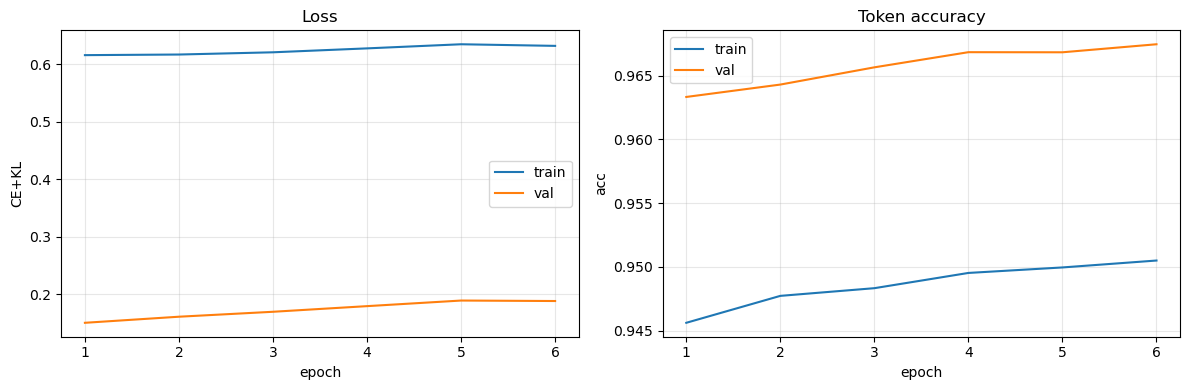

In [9]:
import matplotlib.pyplot as plt
epochs = range(1, len(history["train_loss"])+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="train")
plt.plot(epochs, history["val_loss_tf"],   label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("CE+KL"); plt.grid(alpha=0.3); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="train")
plt.plot(epochs, history["val_acc_tf"],   label="val")
plt.title("Token accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

In [10]:
Dye_smiles = [
'CC1=CC(=O)c2c(Br)cc(Br)c(S(=O)(=O)O)c2C1=O',
'Cc1c(Br)cc(Br)c(C(C)c2ccc(C(C)C)c(Br)c2O)c1S(=O)(=O)O',
'Cc1ccccc1N=Nc1ccc(C(N)=O)cc1',
'Cc1ccc(-c2cccc(O)c2C(C)c2ccc(S(=O)(=O)O)cc2)cc1',
'CN(C)c1ccc2c(c1)CN=C2c1ccccc1',
'O=C1c2ccccc2C(=O)c2c(O)cccc21',
'O=C1Nc2ccccc2S(=O)(=O)[N-]c2c1cccc2S(=O)(=O)[O-]',
'CN(C)C1=CS(=O)(=O)c2ccc(N(C)C)cc21',
'CN(C)c1ccc(C(C)(c2ccc(N(C)C)cc2)c2ccc(N(C)C)cc2)cc1',
'Cc1ccc(C(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccc(C(C)C)cc2)cc1',
'CN(C)c1ccc2c(c1)CC1=CC(=[N+](C)C)C(=N2)C=C1',
'O=C1c2cc(=O)cccc2C(=O)c2c(Br)cc(Br)cc21',
'O=c1cc(O)ccc(-c2ccc3c(oc(=O)c4ccccc43)c2O)c1']

In [11]:
# quick checksum
s = sum(p.detach().float().abs().sum().item() for p in m.parameters())
print("Model checksum:", s)

df_rec = reconstruct_smiles_table(
    smiles_list=None,
    test_csv="/home/md_halim_mondol/Data/VOC_Dye.csv",
    model=m,
    token_to_idx=token_to_idx,
    idx_to_token=idx_to_token,
    seq_length=cfg["seq_length"],
    pad_idx=cfg["pad_idx"],
    sos_idx=cfg["sos_idx"],
    eos_idx=cfg["eos_idx"],
    device=device,
    mode="beam",
    beam_size=cfg["beam_size"])

df_rec.tail(20)

Model checksum: 206157.24729967117


,input,reconstructed,valid,lev
940,CN(C)C,CN(C)Cc1cc[nH+]c(OC)n1,yes,16
941,CN(C)C,CN[C@H](C)c1ccn(C)c1,yes,14
942,CN(C)C,CN(C)C1CC1)(=O)N,no,10
943,CN(C)C,CN[C@H](c1ccsc1N)C(=O),yes,17
944,CN(C)C,CN(C)Cc1cc[nH+]c(C(=O)[O-],no,20
945,CN(C)C,CN(C)CO)CC[NH+]1,no,10
946,CN(C)C,CN(C)Cc1cc[nH+]c(=O)s1,yes,16
947,CN(C)C,CN(C)C(F)F)CN,no,7
948,CN(C)C,CN(C)C(=O)C,yes,5
949,CN(C)C,CN(C)COc1ncc[nH]1,yes,11


In [12]:
# ------------------------------------------------------------------
# 1.  Token-level accuracy (micro-average over SMILES tokens)
# ------------------------------------------------------------------
def token_accuracy_row(gold, pred):
    g = du.tokenize_smiles(gold)
    p = du.tokenize_smiles(pred)
    L = min(len(g), len(p))
    if L == 0:                      # degenerate empty case
        return 0, 0
    correct = sum(gi == pi for gi, pi in zip(g[:L], p[:L]))
    total   = L
    return correct, total

tot_corr = tot_tok = 0
for g, p in zip(df_rec["input"], df_rec["reconstructed"]):
    c, t = token_accuracy_row(g, p)
    tot_corr += c
    tot_tok  += t

beam_token_acc = tot_corr / tot_tok if tot_tok else 0.0
print(f"Token level test accuracy (beam): {beam_token_acc:.4f}")

# ------------------------------------------------------------------
# 2.  Sequence-level (exact-match) accuracy
# ------------------------------------------------------------------
exact_match_acc = (df_rec["input"] == df_rec["reconstructed"]).mean()
print(f"Exact SMILES match accuracy (beam): {exact_match_acc:.4f}")

Token level test accuracy (beam): 0.4642
Exact SMILES match accuracy (beam): 0.0625
